# 01_prepare_riceleaf

**Objective:**  
Prepare the *Rice Leaf Disease* dataset for image classification model training by:
- Organizing the dataset into train, validation, and test sets  
- Maintaining balanced class representation (stratified split)  
- Saving a metadata file (`labels.csv`) for reproducibility


In [1]:
import os
import shutil
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ⚙️ Actual dataset path (update if needed)
BASE_DIR = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\raw\rice-leaf-disease\RiceLeafsDisease")

# Check if there’s a 'train' folder or if classes are directly under BASE_DIR
TRAIN_DIR = BASE_DIR / "train" if (BASE_DIR / "train").exists() else BASE_DIR
PROCESSED_DIR = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\processed\riceleaf")

# Create output folders
(PROCESSED_DIR / "train").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "val").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "test").mkdir(parents=True, exist_ok=True)

print("✅ Base directory:", BASE_DIR)
print("Detected class folders:", [f.name for f in TRAIN_DIR.iterdir() if f.is_dir()])


✅ Base directory: C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\raw\rice-leaf-disease\RiceLeafsDisease
Detected class folders: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


Collect image paths and labels

In [2]:
# Gather all image paths and labels
image_paths = []
labels = []

for class_dir in TRAIN_DIR.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.glob("*.jpg"):
            image_paths.append(img_path)
            labels.append(class_dir.name)

df = pd.DataFrame({"filepath": image_paths, "label": labels})
print(f"✅ Total images found: {len(df):,}")
df.head()


✅ Total images found: 2,100


,filepath,label
0,C:\Users\User\Desktop\Data Science\Projects\cr...,bacterial_leaf_blight
1,C:\Users\User\Desktop\Data Science\Projects\cr...,bacterial_leaf_blight
2,C:\Users\User\Desktop\Data Science\Projects\cr...,bacterial_leaf_blight
3,C:\Users\User\Desktop\Data Science\Projects\cr...,bacterial_leaf_blight
4,C:\Users\User\Desktop\Data Science\Projects\cr...,bacterial_leaf_blight


Encode labels and splits

In [5]:
# Encode labels numerically for reference
df["label_id"] = df["label"].astype("category").cat.codes
label_map = dict(enumerate(df["label"].astype("category").cat.categories))
print("Label map:", label_map)

# Stratified split: 80/10/10
train_df, temp_df = train_test_split(df, test_size=0.20, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Label map: {0: 'bacterial_leaf_blight', 1: 'brown_spot', 2: 'healthy', 3: 'leaf_blast', 4: 'leaf_scald', 5: 'narrow_brown_spot'}
Train: 1680 | Val: 210 | Test: 210


Copy images into split folders

In [6]:
def copy_images(df_split, split_name):
    split_dir = PROCESSED_DIR / split_name
    for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copying {split_name} images"):
        class_dir = split_dir / row["label"]
        class_dir.mkdir(parents=True, exist_ok=True)
        dst_path = class_dir / row["filepath"].name
        if not dst_path.exists():
            shutil.copy(row["filepath"], dst_path)

copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")


Copying test images: 100%|██████████| 210/210 [00:00<00:00, 335.99it/s]


Save metadata

In [7]:
# Add split column for reference
train_df["split"] = "train"
val_df["split"] = "val"
test_df["split"] = "test"

full_df = pd.concat([train_df, val_df, test_df], axis=0)
meta_path = PROCESSED_DIR / "labels.csv"
full_df.to_csv(meta_path, index=False)
print("✅ Metadata saved to:", meta_path)


✅ Metadata saved to: C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\processed\riceleaf\labels.csv


Summary check

In [8]:
summary = (
    full_df.groupby(["split", "label"])
    .size()
    .reset_index(name="count")
    .pivot(index="label", columns="split", values="count")
    .fillna(0)
    .astype(int)
)

summary["total"] = summary.sum(axis=1)
summary


split,test,train,val,total
label,,,,
bacterial_leaf_blight,35,280,35,350
brown_spot,35,280,35,350
healthy,35,280,35,350
leaf_blast,35,280,35,350
leaf_scald,35,280,35,350
narrow_brown_spot,35,280,35,350


Visualize distribution

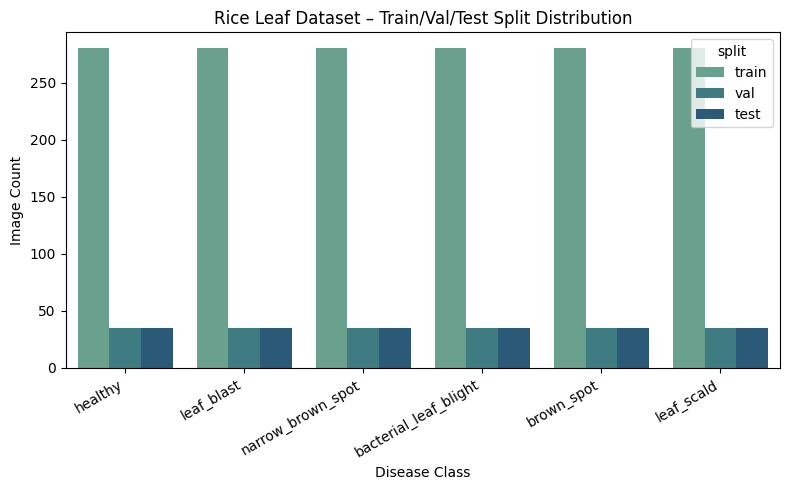

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=full_df, x="label", hue="split", palette="crest")
plt.title("Rice Leaf Dataset – Train/Val/Test Split Distribution")
plt.xticks(rotation=30, ha="right")
plt.xlabel("Disease Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()


## Summary

- Dataset successfully organized into stratified splits.  
- Folder structure prepared for CNN or ViT training.  
- Metadata file (`labels.csv`) includes file paths and labels.  

Final output structure:
